In [1]:
!pip install git+https://github.com/Farama-Foundation/MAgent2
!git clone https://github.com/giangbang/RL-final-project-AIT-3007.git

  Cloning https://github.com/Farama-Foundation/MAgent2 to /tmp/pip-req-build-gbd03664
  Running command git clone --filter=blob:none --quiet https://github.com/Farama-Foundation/MAgent2 /tmp/pip-req-build-gbd03664
  Resolved https://github.com/Farama-Foundation/MAgent2 to commit b2ddd49445368cf85d4d4e1edcddae2e28aa1406
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 57.3 MB/s eta 0:00:00
  Created wheel for magent2: filename=magent2-0.3.3-cp310-cp310-linux_x86_64.whl size=1696110 sha256=b32cd24d9199e9edfc9bfc186ddba10f83aa28c27086037cf2246a52cf3b8d83
  Stored in directory: /tmp/pip-ephem-wheel-cache-65qcjcfx/wheels/e4/8e/bf/51a30bc4038546e23b81c9fb513fe6a8fd916e5a9c5f4291d5
Successfully built magent2
Cloning into 'RL-final-project-AIT-3007'...
remote: Enumerating

In [2]:
import sys
sys.path.append('RL-final-project-AIT-3007')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from collections import deque, Counter, defaultdict
import os
from magent2.environments import battle_v4
import time

In [3]:
class MyQNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], 8, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
        )

        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]

        self.fc = nn.Sequential(
            nn.Linear(flatten_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, action_shape)
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        out = self.cnn(x)

        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]

        out = out.reshape(batchsize, -1)
        return self.fc(out)

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, index):
        return self.buffer[index]


In [5]:
class Trainer:
    def __init__(self, env, config_qnet=None, input_shape=None, action_shape=None, learning_rate=1e-3):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = MyQNetwork(input_shape, action_shape).to(self.device)
        self.target_network = MyQNetwork(input_shape, action_shape).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.steplr = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=1, gamma=0.9)
        self.replay_buffer = ReplayBuffer(capacity=60000)

        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.97
        self.update_target_every = 3

        self.blue_rewards_history = []
        self.red_rewards_history = []

    def select_action(self, observation, agent):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space(agent).sample()

        observation = torch.FloatTensor(observation).unsqueeze(0).to(self.device)

        with torch.inference_mode():
            q_values = self.q_network(observation)

        if np.random.rand() <= self.epsilon * 0.1:
            exp_q_values = torch.exp(q_values).cpu().numpy().flatten()
            action_probabilities = exp_q_values / exp_q_values.sum()
            return np.random.choice(len(action_probabilities), p=action_probabilities)

        return torch.argmax(q_values, dim=1).item()

    def training(self, episodes=100, batch_size=1024):
        start_time = time.time()
        for episode in range(episodes):
            self.env.reset()
            total_blue_reward = 0
            total_red_reward = 0
            reward_for_agent = {agent: 0 for agent in self.env.agents if agent.startswith('blue')}
            prev_observation = {}
            prev_action = {}
            step = 0

            for idx, agent in enumerate(self.env.agent_iter()):
                step += 1
                observation, reward, termination, truncation, info = self.env.last()
                observation = np.transpose(observation, (2, 0, 1))

                agent_handle = agent.split('_')[0]

                if agent_handle == 'blue':
                    total_blue_reward += reward
                    reward_for_agent[agent] += reward
                elif agent_handle == 'red':
                    total_red_reward += reward

                if termination or truncation:
                    action = None
                else:
                    if agent_handle == 'blue':
                        action = self.select_action(observation, agent)
                    else:
                        action = self.env.action_space(agent).sample()

                if agent_handle == 'blue':
                    if agent in prev_observation and agent in prev_action:
                        self.replay_buffer.add(
                            prev_observation[agent],
                            prev_action[agent],
                            reward,
                            observation,
                            termination
                        )

                    prev_observation[agent] = observation
                    prev_action[agent] = action

                self.env.step(action)

            if len(self.replay_buffer) >= batch_size:
                dataloader = DataLoader(self.replay_buffer, batch_size=batch_size, shuffle=True, drop_last=True)
                self.update_model(dataloader)

            if (episode + 1) % self.update_target_every == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())
                self.steplr.step()

            self.blue_rewards_history.append(total_blue_reward)
            self.red_rewards_history.append(total_red_reward)

            elapsed_time = time.time() - start_time  # Tính thời gian huấn luyện
            print(f"Episode {episode + 1}: Blue Reward: {total_blue_reward}, Red Reward: {total_red_reward}, "
                  f"Steps: {step}, Epsilon: {self.epsilon:.2f}, lr: {self.steplr.get_last_lr()}")

            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        total_training_time = time.time() - start_time
        print(f"training time: {total_training_time:.2f}s")

    def update_model(self, dataloader):
        self.q_network.train()
        for states, actions, rewards, next_states, dones in dataloader:
            states = states.to(dtype=torch.float32, device=self.device)
            actions = actions.to(dtype=torch.long, device=self.device)
            rewards = rewards.to(dtype=torch.float32, device=self.device)
            next_states = next_states.to(dtype=torch.float32, device=self.device)
            dones = dones.to(dtype=torch.float32, device=self.device)

            current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

            with torch.inference_mode():
                next_actions = self.q_network(next_states).argmax(1)
                next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)

            expected_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

            loss = self.criterion(current_q_values, expected_q_values)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def plot_results(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(self.blue_rewards_history, label="Blue Team Reward", color="blue")
        plt.plot(self.red_rewards_history, label="Red Team Reward", color="red")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title("Rewards per Episode")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.smooth(self.blue_rewards_history), label="Smoothed Blue Team Reward", color="blue")
        plt.plot(self.smooth(self.red_rewards_history), label="Smoothed Red Team Reward", color="red")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title("Smoothed Rewards per Episode")
        plt.legend()

        plt.tight_layout()
        plt.show()

    @staticmethod
    def smooth(data, window_size=10):
        if len(data) < window_size:
            return data
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

Episode 1: Blue Reward: -3306.490120554343, Red Reward: -3319.4651210624725, Steps: 161316, Epsilon: 1.00, lr: [0.001]
Episode 2: Blue Reward: -3221.5001170402393, Red Reward: -3237.3101173723117, Steps: 159730, Epsilon: 0.97, lr: [0.001]
Episode 3: Blue Reward: -3053.470112476498, Red Reward: -3151.4301152825356, Steps: 157059, Epsilon: 0.94, lr: [0.0009000000000000001]
Episode 4: Blue Reward: -3096.765110803768, Red Reward: -3214.38511581067, Steps: 158302, Epsilon: 0.91, lr: [0.0009000000000000001]
Episode 5: Blue Reward: -2937.570106229745, Red Reward: -3144.9401144701988, Steps: 157997, Epsilon: 0.89, lr: [0.0009000000000000001]
Episode 6: Blue Reward: -2906.370103234425, Red Reward: -3280.9701199382544, Steps: 160674, Epsilon: 0.86, lr: [0.0008100000000000001]
Episode 7: Blue Reward: -2820.1501000514254, Red Reward: -3209.1751174572855, Steps: 160951, Epsilon: 0.83, lr: [0.0008100000000000001]
Episode 8: Blue Reward: -2753.3650959897786, Red Reward: -3283.400119781494, Steps: 161

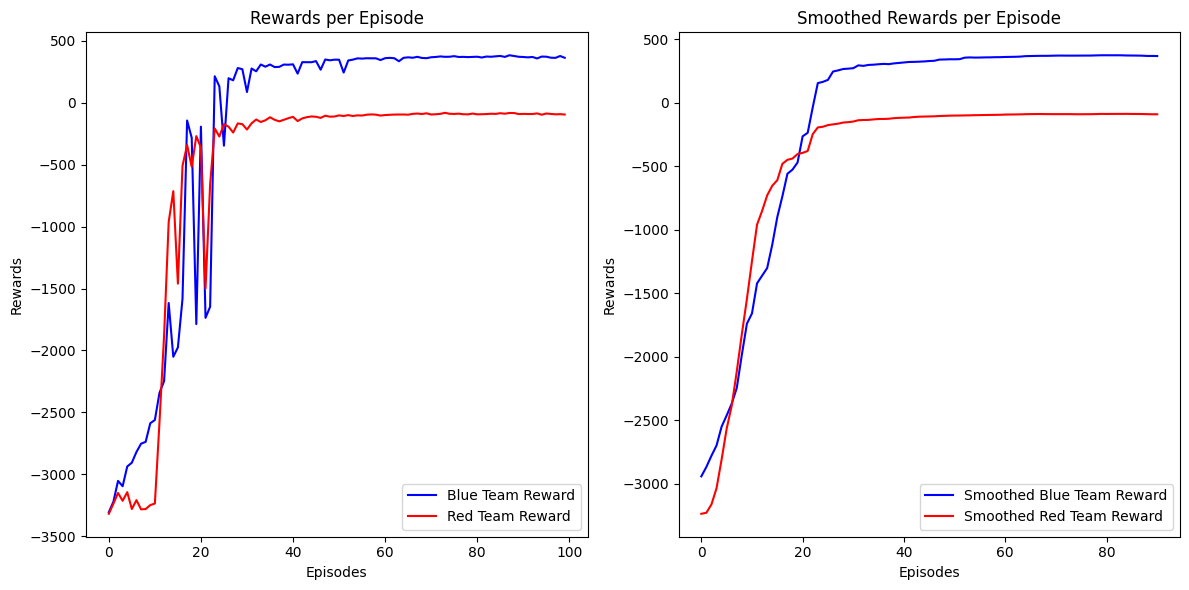

In [6]:
env = battle_v4.env(map_size=45, render_mode=None)
trainer = Trainer(env, input_shape=env.observation_space("red_0").shape, action_shape=env.action_space("red_0").n)
trainer.training(episodes=100)
trainer.plot_results()

In [7]:
os.makedirs("RL-final-project-AIT-3007", exist_ok=True)
torch.save(trainer.q_network.state_dict(), "RL-final-project-AIT-3007/blue_final.pt")
print("Training complete. Model saved.")

Training complete. Model saved.
